# Exercise 2

## Rice, Huffman and FLAC

# Table of Contents
1. [Installation of Libraries](#installation)
2. [Common Functions](#common)
3. [Rice Coding](#rice)
4. [Rice Table Analysis](#riceanalysis)
5. [Rice Histogram](#ricehistogram)
6. [References - Rice](#ricereferences)
7. [Huffman Coding](#huffman)
8. [Comparison Table for Rice and Huffman coding](#huffmananalysis)
9. [References - Huffman](#huffmanreferences)
10. [FLAC](#flac)
11. [Comparison Table of Rice, Huffman and FLAC](#allcodinganalysis)
12. [Comparison Bar Chart of Rice, Huffman and FLAC](#allcodinganalysisbarchart)
13. [References - FLAC](#flacreferences)
14. [Conclusion](#conclusion)

<a id='installation'></a>
## Installation of Libraries
This section will handle installation and import of necessary libraries to run alll code in this Notebook

#### install huffman, pydub and ffmpeg

In [1]:
!pip install huffman
!pip install pydub
!pip install ffmpeg-python


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


#### adding path for Jupyter Notebooks to recognize ffmpeg

In [2]:
import os
os.environ['PATH'] = '/usr/local/bin:' + os.environ['PATH']

#### checks path configuration

In [3]:
import shutil
shutil.which("ffmpeg")

'/usr/local/bin/ffmpeg'

#### import libraries

In [4]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile
import matplotlib.pyplot as plt
import heapq
import pickle
from collections import Counter
from pydub import AudioSegment

<a id='common'></a>
## Common Functions
#### This section includes common functions used through the Notebook.

**data_size** function handles conversion from bytes to data sizes (B, KB, MB, GB, TB) for Rice, Huffman and FLAC

**parameters:**
- size: file size in bytes
- decimal: default 2

In [5]:
def data_size(size, decimal=2):
    # units based on power of 10 (B, KB, MB, GB, TB)
    data_units = [10**0, 10**3, 10**6, 10**9, 10**12]  
    # lables for data 
    data_labels = ['B', 'KB', 'MB', 'GB', 'TB']
    
    for index, unit in enumerate(data_units):
        if size < unit * 1000:
            return f"{size/unit:.{decimal}f} {data_labels[index]}"
    
    return f"{size/10**12:.{decimal}f} TB"

**wave_visualization** function handles waveform visualization for Rice, Huffman and FLAC

In [6]:
def wave_visualization(base_data, decoded_data, rate, coding_method=None, k=None, audio_file_name=""):
    time = np.linspace(0., len(base_data) / rate, len(base_data))
    
    # get audio file name from path 
    base_name = os.path.basename(audio_file_name)

    # if it's a rice coding then title is based on k-value, otherwise, it's based on coding method
    if coding_method == "rice":
        base_wave_title = f"{base_name} - Original Wave for K={k}"
        decoded_wave_title = f"{base_name} - Decoded Wave for K={k}"
        comparison_wave_title = f"{base_name} - Wave Comparison for K={k}"
    else:
        base_wave_title = f"{base_name} - Original Wave"
        decoded_wave_title = f"{base_name} - Decoded Wave ({coding_method.capitalize()})"
        comparison_wave_title = f"{base_name} - Layered: Original vs {coding_method.capitalize()} Decoded Wave"

    # base waveform plot
    plt.figure(figsize=(8, 2))  
    plt.plot(time, base_data, marker=None)  
    plt.title(base_wave_title)
    plt.xlabel("time (secs)")
    plt.ylabel("amplitude")
    plt.show()

    # decoded waveform plot
    plt.figure(figsize=(8, 2))  
    plt.plot(time, decoded_data, color="purple", marker=None)  
    plt.title(decoded_wave_title)
    plt.xlabel("time (secs)")
    plt.ylabel("amplitude")
    plt.show()

    # layer both waveforms for comparison
    plt.figure(figsize=(8, 2))  
    plt.plot(time, base_data, marker=None)  
    plt.plot(time, decoded_data, alpha=0.4, marker=None)  
    plt.title(comparison_wave_title)
    plt.xlabel("time (secs)")
    plt.ylabel("amplitude")
    plt.show()

<a id='rice'></a>
## Rice Coding

,File Name,K,Original Sample #,Decoded Sample #,All Samples Status,1st 5 Original Samples,1st 5 Decoded Samples
0,Sound1.wav,2,"501,022","501,022",Match,"-7, -7, -7, -7, -8","-7, -7, -7, -7, -8"
1,Sound1.wav,4,"501,022","501,022",Match,"-7, -7, -7, -7, -8","-7, -7, -7, -7, -8"


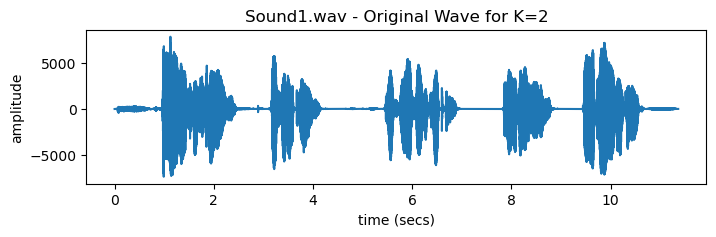

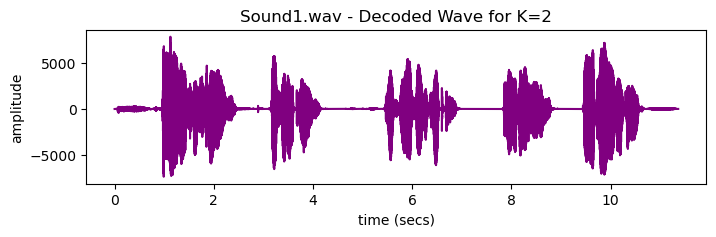

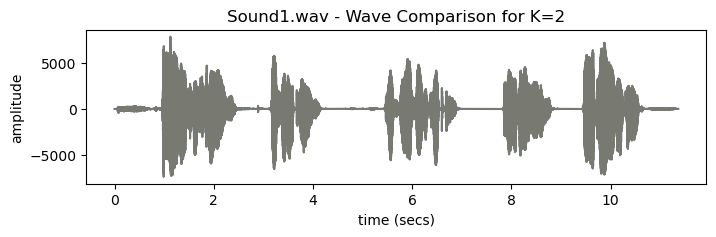

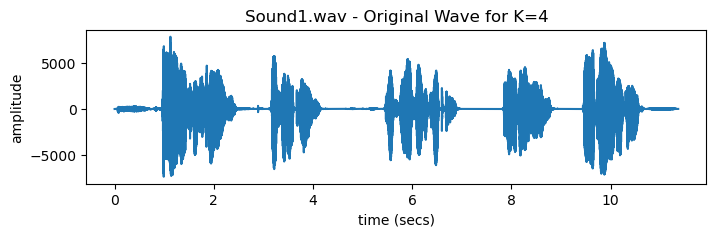

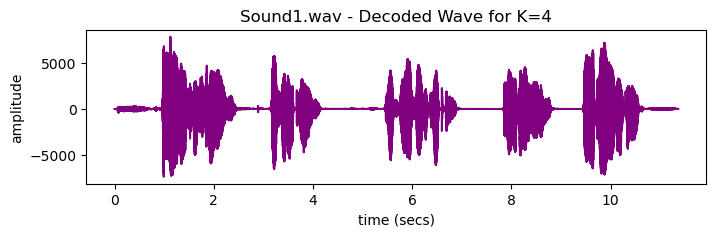

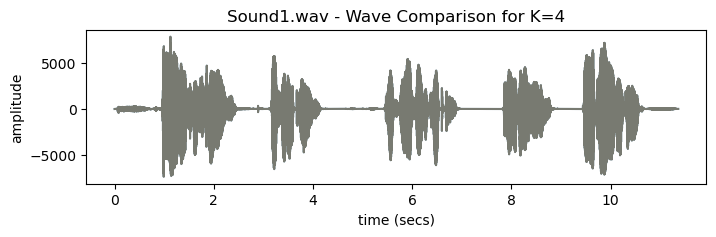

,File Name,K,Original Sample #,Decoded Sample #,All Samples Status,1st 5 Original Samples,1st 5 Decoded Samples
0,Sound2.wav,2,"504,000","504,000",Match,"-999, 886, -1325, 886, -1514","-999, 886, -1325, 886, -1514"
1,Sound2.wav,4,"504,000","504,000",Match,"-999, 886, -1325, 886, -1514","-999, 886, -1325, 886, -1514"


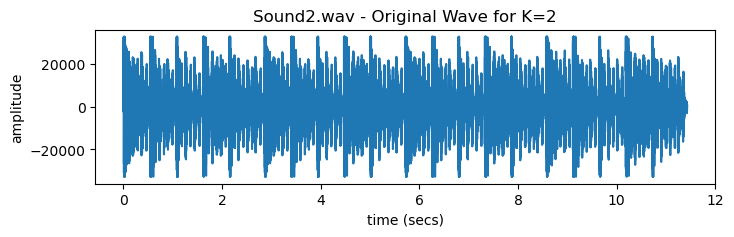

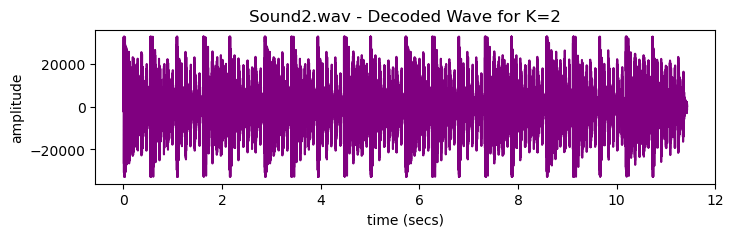

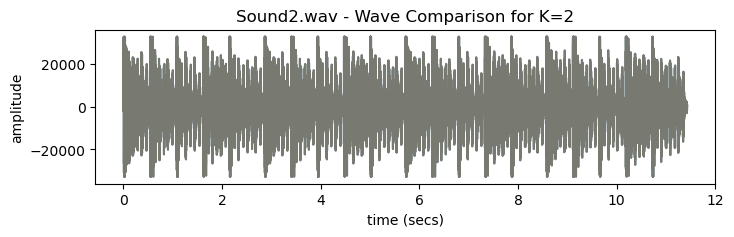

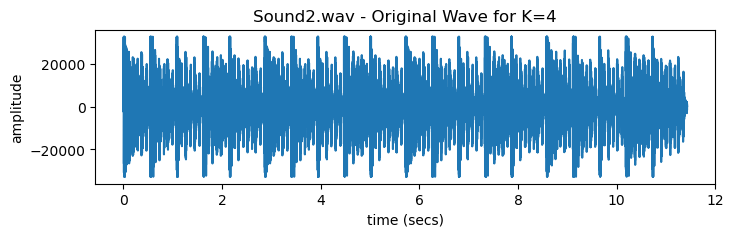

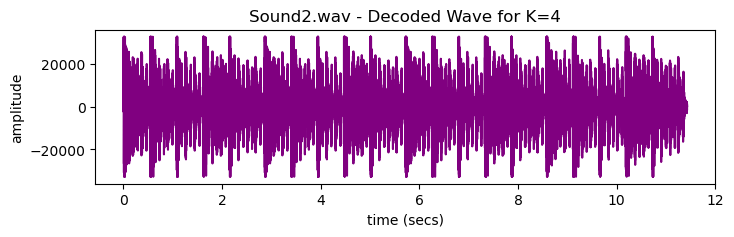

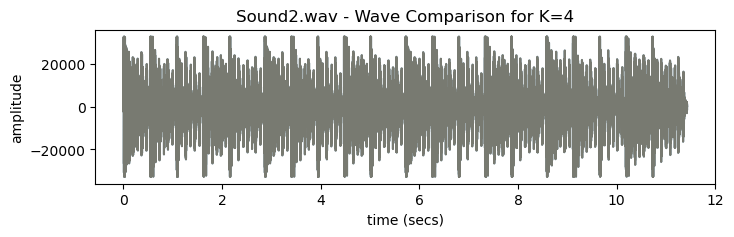

In [7]:
# applies padding to encoded data to make sure data length is a multiple of 8
def apply_padding(encoded_data):
    # determines the number of bits required for padding to make the final length a multiple of 8
    padding = 8 - len(encoded_data) % 8
    # if the value is a multiple of 8, padding is not added
    padding = padding % 8  
    # creates padding string
    padding_string = '0' * padding
    # 1st byte is padding details
    padding_details = format(padding, '08b')
    return padding_details + encoded_data + padding_string

# delete padding from encoded data according to the padding details contained in the first 8 bits
def delete_padding(padding_with_encoded_data):
    get_padding = int(padding_with_encoded_data[:8], 2)
    return padding_with_encoded_data[8:-get_padding] if get_paddingg != 0 else padding_with_encoded_data[8:]

# verify the folder exists, if not, create folder
def verify_folder_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

#  stores/saves encoded data in a file after adding padding in folder "rice_coding" 
def store_encoded_data(audio_file_name, encoded_data):
    verify_folder_exists('rice_coding')
    encoded_file_path = os.path.join('rice_coding', os.path.basename(audio_file_name))
    
    # before saving adds padding to encoded data 
    encoded_data_with_padding = apply_padding(encoded_data)
    byte_representation = int(encoded_data_with_padding, 2).to_bytes((len(encoded_data_with_padding) + 7) // 8, 'big')
    with open(encoded_file_path, 'wb') as f:
        f.write(byte_representation)

# retrieves encoded data from a file in the 'rice_coding' folder and deletes padding, if any
def retrieve_encoded_data(filename):
    encoded_file_path = os.path.join('rice_coding', os.path.basename(filename))
    
    with open(encoded_file_path, 'rb') as f:
        data_in_byte = f.read()
        encoded_data_with_padding = bin(int.from_bytes(data_in_byte, 'big'))[2:].rjust(len(data_in_byte) * 8, '0')
    return delete_padding(encoded_data_with_padding)

# encode using Rice on provided int data
# parameters: int_data - integer value to encode; k - determines divisor for quotient and remainder calc
def encode_using_rice(int_data, k):
    quotient, remainder = divmod(int_data, 2**k)
    # unary representation of quotient
    unary_representation = '1' * quotient + '0' 
    # binary representation of remainder
    binary_representation = format(remainder, '0' + str(k) + 'b') 
    # rice encoded bit string
    return unary_representation + binary_representation 

# decode using rice encoded bit string to int value, where k is parameter for decoding
def decode_using_rice(encoded_bit_string, k):
    unary_representation = encoded_bit_string.find('0')
    quotient = unary_representation
    remainder = int(encoded_bit_string[unary_representation+1:unary_representation+k+1], 2)
    return quotient * (2**k) + remainder # decoded integer value

# encode audio data where array_of_audio_samples is integers and k is parameter for rice encoding
def encode_audio_data(array_of_audio_samples, k):
    offset = 32768  # to make sure data is +
    # returns concatenated bit string 
    return ''.join([encode_using_rice(sample + offset, k) for sample in array_of_audio_samples])

#  decode encoded audio data back to audio samples where encoded_data is bit string and k is parameter for decoding
def decode_audio_data(encoded_data, k):
    offset = 32768  # to make sure data is +
    i = 0
    decoded_samples_array = []
    
    while i < len(encoded_data):
        unary_end = encoded_data.find('0', i)
        sample = decode_using_rice(encoded_data[i:unary_end+k+1], k) - offset
        decoded_samples_array.append(sample)
        i = unary_end + k + 1
    # returns array of decoded audio samples
    return np.array(decoded_samples_array, dtype=np.int16)

# compress audio files using rice encoding and decoding and display wave visualization where k_values are set to default 2, 4
def compress_audio_with_rice(audio_files_paths, k_values=[2, 4], audio_sample_size=5):
    # verify directory exists
    if not os.path.exists('rice_coding'):
        os.makedirs('rice_coding')

    for audio_file_name in audio_files_paths:
        data_table = []  

        # reads WAV
        rate, data = wavfile.read(audio_file_name)
        
        for k in k_values:
            # encodes data
            encoded_data = encode_audio_data(data, k)
            
            # saves encoded data with specified file name
            encoded_file_path = os.path.join('rice_coding', os.path.basename(audio_file_name.replace('.wav', '_Enc_K' + str(k) + '.ex2')))
            with open(encoded_file_path, 'wb') as f:
                pickle.dump(encoded_data, f)
            
            # reads encoded data
            with open(encoded_file_path, 'rb') as f:
                read_encoded_data = pickle.load(f)
            
            # decodes data
            decoded_data = decode_audio_data(read_encoded_data, k)
            
            # checks if samples match
            sample_match_status = "Match" if np.array_equal(data, decoded_data) else "Mismatch"
            
            # saves decoded data in folder with specified name
            decoded_file_path = os.path.join('rice_coding', os.path.basename(audio_file_name.replace('.wav', '_Enc_Dec_K' + str(k) + '.wav')))
            wavfile.write(decoded_file_path, rate, decoded_data)
            
            # add results to table 
            data_table.append({
                "File Name": os.path.basename(audio_file_name),
                "K": k,
                "Original Sample #": len(data),
                "Decoded Sample #": len(decoded_data),
                "All Samples Status": sample_match_status,
                "1st 5 Original Samples": data[:audio_sample_size],
                "1st 5 Decoded Samples": decoded_data[:audio_sample_size]
            })
            
        # style and show table for audio
        df = pd.DataFrame(data_table)
        styled_df = df.style.format({
            "Original Sample #": "{:,}",
            "Decoded Sample #": "{:,}",
            "1st 5 Original Samples": lambda x: ", ".join(map(str, x)),
            "1st 5 Decoded Samples": lambda x: ", ".join(map(str, x)),
        })
        display(styled_df)
        
        # wave for all k values to be shown after table 
        for k in k_values:
            wave_visualization(data, decode_audio_data(encode_audio_data(data, k), k), rate, coding_method="rice", k=k, audio_file_name=audio_file_name)

audio_files_paths = ['original_audio/Sound1.wav', 'original_audio/Sound2.wav']
compress_audio_with_rice(audio_files_paths)

<a id='riceanalysis'></a>
## Rice Table Analysis
The code analyzes the compression of audio files using Rice encoding. For each file and specified 'k' value, it calculates the original and compressed sizes, computes the compression ratio, and assembles this data into a table using pandas. The table is then styled for clear presentation and displayed.

In [8]:
# this function analyzes rice compression and displays data table
def analyze_rice_compression(audio_files_paths, k_values=[2, 4]):
    rows = []
    
    for audio_file_name in audio_files_paths:
        # obtains size of file
        get_original_size = os.path.getsize(audio_file_name)  
        row = {'File Name': os.path.basename(audio_file_name), 'Original Size': get_original_size}
        
        for k in k_values:
            # creates path to location of encoded file based on 'k' value and original file name
            encoded_file_path = audio_file_name.replace('original_audio/', 'rice_coding/').replace('.wav', f'_Enc_K{k}.ex2')
            # obtainssize of encoded file
            get_encoded_size = os.path.getsize(encoded_file_path)  
            
            ratio_of_compression = get_encoded_size / get_original_size
            percentage_of_compression = (1 - ratio_of_compression) * 100
            
            # if result is negative show 0% and negative value 
            if percentage_of_compression < 0:
                string_of_compression = f"0.00% ({percentage_of_compression:.2f}%)"
            else:
                string_of_compression = f"{percentage_of_compression:.2f}%"
            
            row[f"Rice (K = {k} bits)"] = get_encoded_size
            row[f"% Compression (K = {k} bits)"] = string_of_compression
            
        rows.append(row)
    
    # order of columns 
    order = ['File Name', 'Original Size'] + \
            [f"Rice (K = {k} bits)" for k in reversed(k_values)] + \
            [f"% Compression (K = {k} bits)" for k in reversed(k_values)]
    
    df = pd.DataFrame(rows, columns=order)  
    return df


audio_files_paths = ['original_audio/Sound1.wav', 'original_audio/Sound2.wav']
df = analyze_rice_compression(audio_files_paths)

# format table
df_formatted = df.style.format({
    'Original Size': data_size,
    'Rice (K = 2 bits)': data_size,
    'Rice (K = 4 bits)': data_size
}) 

display(df_formatted)

,File Name,Original Size,Rice (K = 4 bits),Rice (K = 2 bits),% Compression (K = 4 bits),% Compression (K = 2 bits)
0,Sound1.wav,1.00 MB,1.03 GB,4.11 GB,0.00% (-102522.85%),0.00% (-409614.34%)
1,Sound2.wav,1.01 MB,1.04 GB,4.14 GB,0.00% (-102788.20%),0.00% (-410677.71%)


<a id='ricehistogram'></a>
## Rice Histogram

- **Histogram 1:** exhibits an irregular distribution pattern of audio sample values 
- **Histogram 2:** exhibits significant disparities among consecutive samples

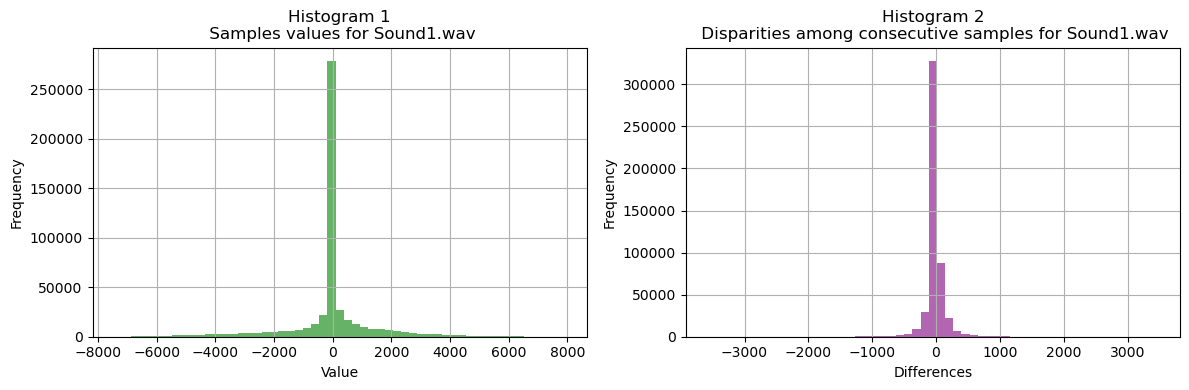

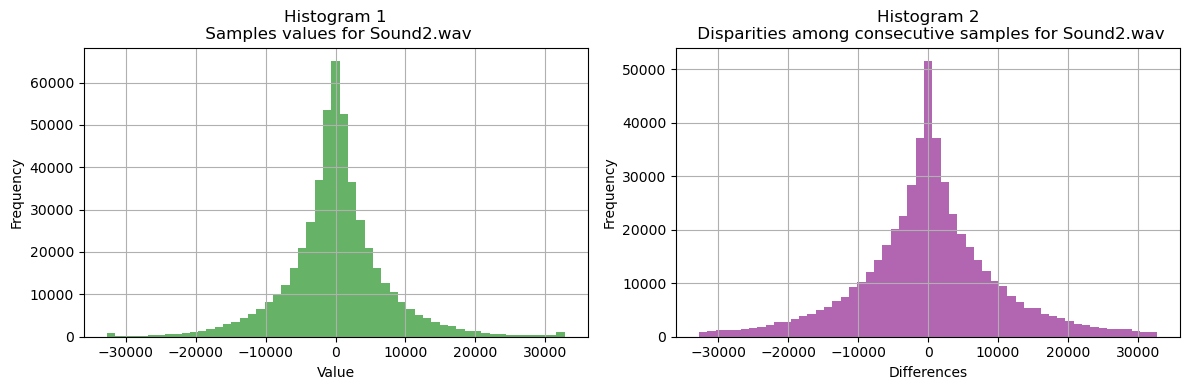

In [9]:
# this function creates histograms to visualy analyze samples
def histogram_audio_analysis(audio_file_name):
    rate, data = wavfile.read(audio_file_name)
    
    # get only file name from path
    get_file_name = os.path.basename(audio_file_name)
    
    # subplots to display histograms in 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # histogram for samples value
    axs[0].hist(data, bins=55, color='green', alpha=0.6)
    axs[0].set_title(f'Histogram 1\n Samples values for {get_file_name}')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')
    axs[0].grid(True)

    # disparities among consecutive samples 
    differences = np.diff(data)
    axs[1].hist(differences, bins=55, color='purple', alpha=0.6)
    axs[1].set_title(f'Histogram 2\n Disparities among consecutive samples for {get_file_name}')
    axs[1].set_xlabel('Differences')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    # space between plots
    plt.tight_layout()
    plt.show()

# analysis of audio files
files = ['original_audio/Sound1.wav', 'original_audio/Sound2.wav']
for file in files:
    histogram_audio_analysis(file)

<a id='ricereferences'></a>
## References - Rice

- https://en.wikipedia.org/wiki/Golomb_coding
- https://en.wikipedia.org/wiki/Padding_(cryptography)#Bit_padding
- https://docs.python.org/3/library/os.path.html
- https://docs.python.org/3/library/os.html#os.makedirs
- https://docs.python.org/3/library/pickle.html
- https://numpy.org/doc/stable/
- https://pandas.pydata.org/docs/
- https://docs.fileformat.com/audio/wav/
- https://gist.github.com/perrygeo/ee7c65bb1541ff6ac770
- https://stackoverflow.com/questions/473282/how-can-i-pad-an-integer-with-zeros-on-the-left
- https://stackoverflow.com/questions/273192/how-do-i-create-a-directory-and-any-missing-parent-directories
- https://www.tutorialspoint.com/How-can-I-create-a-directory-if-it-does-not-exist-using-Python
- https://www.geeksforgeeks.org/python-os-path-basename-method/
- https://realpython.com/python-pathlib/
- https://personales.unican.es/corcuerp/python/tutorial/Python_FileText.html
- https://web.mit.edu/~y_z/work/assorted/python-commons/trunk/src/commons/path.py
- https://www.programiz.com/python-programming/methods/built-in/divmod
- https://community.st.com/t5/other-solutions-mcu/digital-audio-effects-wave-file-issue/m-p/490831
- https://blog.enterprisedna.co/how-to-get-file-size-in-python-a-quick-guide/
- https://note.nkmk.me/en/python-os-basename-dirname-split-splitext/
- https://www.geeksforgeeks.org/understanding-file-sizes-bytes-kb-mb-gb-tb-pb-eb-zb-yb/
- https://stackoverflow.com/questions/12523586/python-format-size-application-converting-b-to-kb-mb-gb-tb
- https://www.ibm.com/docs/en/spectrum-control/5.4.8?topic=concepts-units-measurement-storage-data
- https://pandas.pydata.org/docs/user_guide/style.html

<a id='huffman'></a>
## Huffman Coding

,File Name,Original Sample #,Decoded Sample #,All Samples Status,1st 5 Original Samples,1st 5 Decoded Samples
0,Sound1.wav,501022,501022,Match,[-7 -7 -7 -7 -8],[-7 -7 -7 -7 -8]


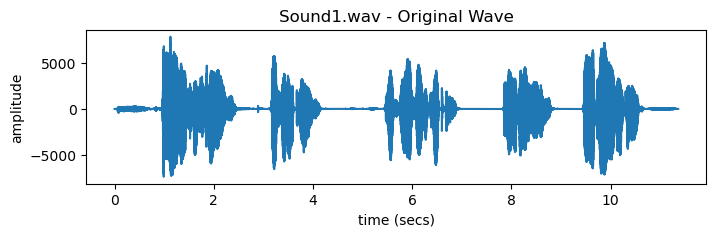

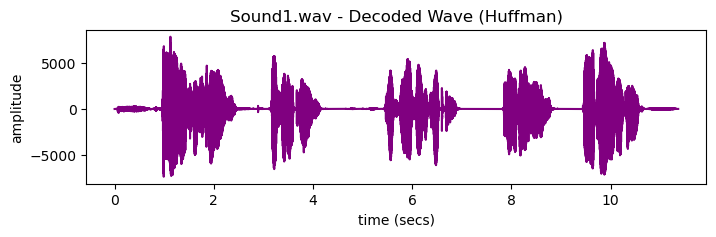

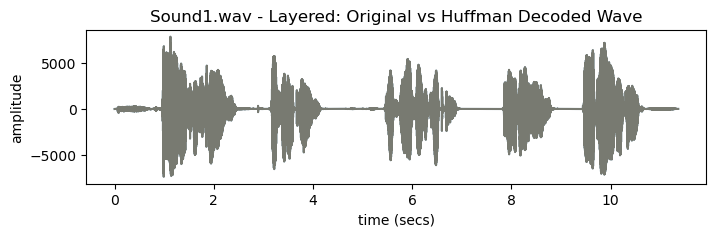

,File Name,Original Sample #,Decoded Sample #,All Samples Status,1st 5 Original Samples,1st 5 Decoded Samples
0,Sound2.wav,504000,504000,Match,[ -999 886 -1325 886 -1514],[ -999 886 -1325 886 -1514]


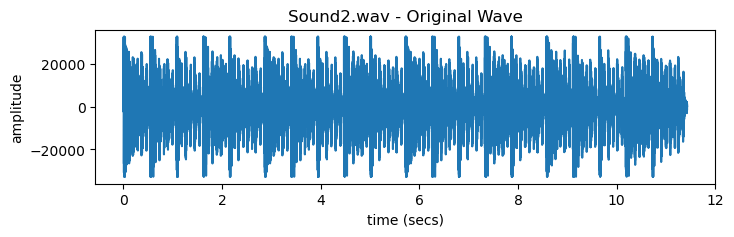

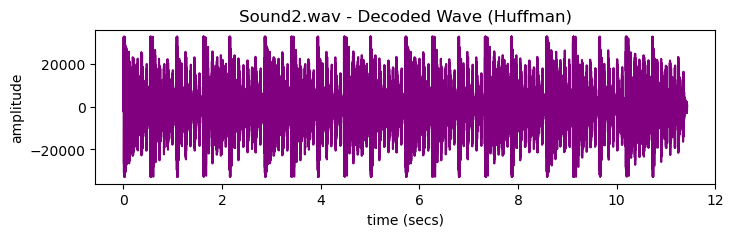

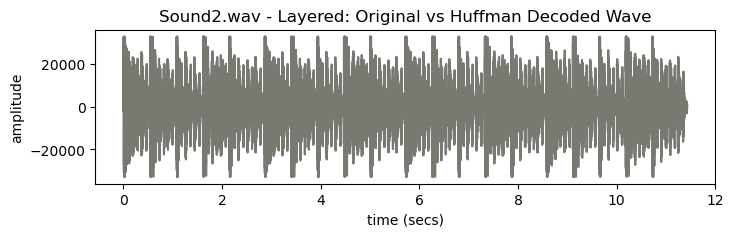

In [10]:
# defines Huffman tree node
class HuffmanTreeNode:
    def __init__(self, value, frequency):
        self.value = value
        self.frequency = frequency
        self.left = None
        self.right = None

    # comparison method for node frequency, used for heap ordering
    def __lt__(self, other):
        return self.frequency < other.frequency

# handles creation of a Huffman Tree from frequency table
def create_huffman_tree(frequency_table):
    # transform every frequency into a HuffmanTreeNode and generate a heap
    heap = [HuffmanTreeNode(value, frequency) for value, frequency in frequency_table.items()]
    heapq.heapify(heap)
     # merge two nodes with least frequencies until last node 
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        
        merge_node = HuffmanTreeNode(None, left.frequency + right.frequency)
        merge_node.left = left
        merge_node.right = right

        heapq.heappush(heap, merge_node)
    
    return heap[0]  # return root node 

# recursive function to assemble Huffman codes 
def assemble_huffman_codes(root):
     # traverses Huffman Tree and creayes codes
    def _assemble_huffman_codes(node, code, map):
        if node is not None:
            if node.value is not None:
                map[node.value] = code
            _assemble_huffman_codes(node.left, code + '0', map)
            _assemble_huffman_codes(node.right, code + '1', map)

    map = {}
    _assemble_huffman_codes(root, '', map)
    return map

# handles encode data
def huffman_encode_data(data, huffman_codes ):
    return ''.join([huffman_codes [val] for val in data])

# handles decoding of encoded data
def huffman_decode_data(encoded_data, huffman_codes ):
    inverse_codes = {code: val for val, code in huffman_codes .items()}
    decoded_data = []
    temporary_bit_storage  = ''
    
    for bit in encoded_data:
        temporary_bit_storage  += bit
        if temporary_bit_storage  in inverse_codes:
            decoded_data.append(inverse_codes[temporary_bit_storage ])
            temporary_bit_storage  = ''
    return np.array(decoded_data, dtype=np.int16)

# handles encoding and decoding
def compress_audio_with_huffman(audio_files_paths, audio_sample_size=5):
    # verify directory exists
    if not os.path.exists('huffman_coding'):
        os.makedirs('huffman_coding')
    
    for audio_file_name in audio_files_paths:
        data_table = []  

        # reads WAV
        rate, base_data = wavfile.read(audio_file_name)

        # encoding
        frequency_table = dict(Counter(base_data))
        tree_root = create_huffman_tree(frequency_table)
        huffman_codes  = assemble_huffman_codes(tree_root)
        encoded_data = huffman_encode_data(base_data, huffman_codes )
        
        # saves encoded data
        encoded_file_path = os.path.join('huffman_coding', os.path.basename(audio_file_name).replace('.wav', '_Huffman_Encoded.ex2'))
        with open(encoded_file_path, 'wb') as f:
            pickle.dump((encoded_data, huffman_codes ), f)

        # reads encoded data
        with open(encoded_file_path, 'rb') as f:
            read_encoded_data, read_huff_codes = pickle.load(f)

        # decoding
        decoded_data = huffman_decode_data(read_encoded_data, read_huff_codes)

        # checks if samples match
        sample_match_status = "Match" if np.array_equal(base_data, decoded_data) else "Mismatch"

        # save decoded data
        decoded_file_path = os.path.join('huffman_coding', os.path.basename(audio_file_name).replace('.wav', '_Huffman_Decoded.wav'))
        wavfile.write(decoded_file_path, rate, decoded_data)

        # add results to data table
        data_table.append({
                "File Name": os.path.basename(audio_file_name),
                "Original Sample #": len(base_data),
                "Decoded Sample #": len(decoded_data),
                "All Samples Status": sample_match_status,
                "1st 5 Original Samples": base_data[:audio_sample_size],
                "1st 5 Decoded Samples": decoded_data[:audio_sample_size]
        })

        df = pd.DataFrame(data_table)

        # format and display table
        df_formatted = df.style.format({
            "Original Sample Count": "{:,}",
            "Decoded Sample Count": "{:,}",
            "First 10 Original Samples": lambda x: ", ".join(map(str, x)),
            "First 10 Decoded Samples": lambda x: ", ".join(map(str, x)),
        })
        display(df_formatted)

        # wave visualization 
        wave_visualization(base_data, decoded_data, rate, coding_method="huffman", audio_file_name=audio_file_name)

audio_files_paths = ['original_audio/Sound1.wav', 'original_audio/Sound2.wav']
compress_audio_with_huffman(audio_files_paths)

<a id='huffmananalysis'></a>
## Comparison Table for Rice and Huffman coding

In [11]:
# this function analyzes huffman and rice compression and displays data table
def analyze_huffman_rice_compression(audio_files_paths, k_values=[2, 4]):
    rows = []

    for file in audio_files_paths:
        get_original_size = os.path.getsize(file)
        row = {'File Name': os.path.basename(file), 'Original Size': get_original_size}
   
        # rice coding details
        for k in k_values:
            rice_coding_encoded_path = os.path.join("rice_coding", file.replace('.wav', '_Enc_K' + str(k) + '.ex2').replace("original_audio/", ""))
            rice_coding_encoded_size = os.path.getsize(rice_coding_encoded_path)
            rice_coding_compression_ratio = rice_coding_encoded_size / get_original_size
            rice_coding_compression_percentage = (1 - rice_coding_compression_ratio) * 100
            rice_coding_string_of_compression = f"{rice_coding_compression_percentage:.2f}%" if rice_coding_compression_percentage >= 0 else f"0.00% ({rice_coding_compression_percentage:.2f}%)"
            
            row[f"Rice (K = {k} bits)"] = rice_coding_encoded_size
            row[f"% Compression (K = {k} bits)"] = rice_coding_string_of_compression
        
        # huffman coding details
        huffman_coding_encoded_path = os.path.join("huffman_coding", file.replace('.wav', '_Huffman_Encoded.ex2').replace("original_audio/", ""))
        huffman_coding_encoded_size = os.path.getsize(huffman_coding_encoded_path)
        huffman_coding_compression_ratio = huffman_coding_encoded_size / get_original_size
        huffman_coding_compression_percent = (1 - huffman_coding_compression_ratio) * 100
        huffman_coding_compression_string = f"{huffman_coding_compression_percent:.2f}%" if huffman_coding_compression_percent >= 0 else f"0.00% ({huffman_coding_compression_percent:.2f}%)"
        
        row['Huffman Encoded Size'] = huffman_coding_encoded_size
        row['% Compression (Huffman)'] = huffman_coding_compression_string
        
        rows.append(row)
    
    # order of columns
    order = ['File Name', 'Original Size', 'Rice (K = 2 bits)', 'Rice (K = 4 bits)', 'Huffman Encoded Size', '% Compression (K = 2 bits)', '% Compression (K = 4 bits)', '% Compression (Huffman)']

    df = pd.DataFrame(rows, columns=order)
    return df

audio_files_paths = ['original_audio/Sound1.wav', 'original_audio/Sound2.wav']
df = analyze_huffman_rice_compression(audio_files_paths)

# formats table 
df_formatted = df.style.format({
    'Original Size': data_size,
    'Rice (K = 2 bits)': data_size,
    'Rice (K = 4 bits)': data_size,
    'Huffman Encoded Size': data_size,
})

display(df_formatted)

,File Name,Original Size,Rice (K = 2 bits),Rice (K = 4 bits),Huffman Encoded Size,% Compression (K = 2 bits),% Compression (K = 4 bits),% Compression (Huffman)
0,Sound1.wav,1.00 MB,4.11 GB,1.03 GB,5.50 MB,0.00% (-409614.34%),0.00% (-102522.85%),0.00% (-448.68%)
1,Sound2.wav,1.01 MB,4.14 GB,1.04 GB,8.69 MB,0.00% (-410677.71%),0.00% (-102788.20%),0.00% (-761.93%)


<a id='huffmanreferences'></a>
## References - Huffman

- https://en.wikipedia.org/wiki/Huffman_coding
- https://www.geeksforgeeks.org/heap-queue-or-heapq-in-python/
- https://www.geeksforgeeks.org/python-counter-objects-elements/
- https://docs.python.org/3/library/wave.html
- https://docs.python.org/3/library/pickle.html
- https://github.com/bhrigu123/huffman-coding/blob/master/huffman.py
- https://github.com/bhrigu123/huffman-coding
- https://github.com/bhrigu123/huffman-coding?search=1
- https://www.mycompiler.io/view/AZYCwEBVhdC
- https://www.geeksforgeeks.org/huffman-coding-using-priority-queue/
- https://rosettacode.org/wiki/Huffman_coding
- https://github.com/heineman/python-data-structures/blob/master/5.%20Heap-based%20Structures/huffman.py
- https://github.com/cicizh/Huffman/blob/master/huffman.py
- https://stackoverflow.com/questions/75509378/how-to-store-string-generated-from-huffman-tree-to-a-text-file
- https://www.geeksforgeeks.org/huffman-coding-greedy-algo-3/
- https://www.reddit.com/r/learnpython/comments/67pagm/huffman_encoding_tree_traversal/?rdt=47323
- https://es.mathworks.com/help/comm/ref/huffmandeco.html
- https://github.com/ybruce61414/Huffman-Code
- https://towardsdatascience.com/huffman-decoding-cca770065bab
- https://www.programiz.com/dsa/huffman-coding

<a id='flac'></a>
## FLAC

,File Name,Original Sample #,Decoded Sample #,All Samples Status,1st 5 Original Samples,1st 5 Decoded Samples
0,Sound1.wav,"501,022","501,022",Match,"-7, -7, -7, -7, -8","-7, -7, -7, -7, -8"


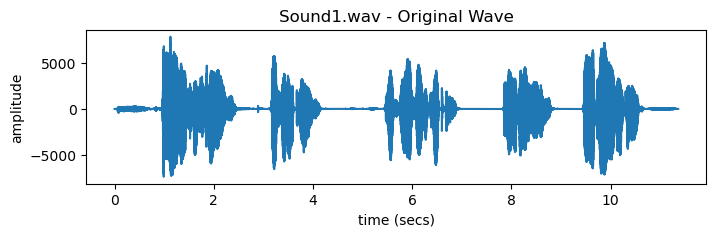

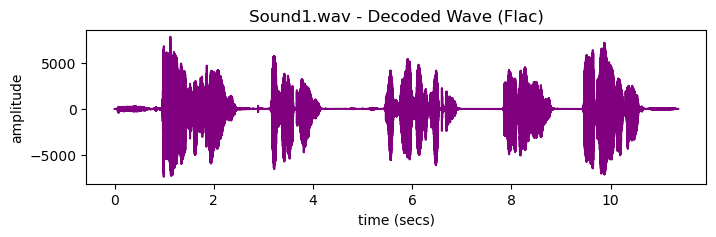

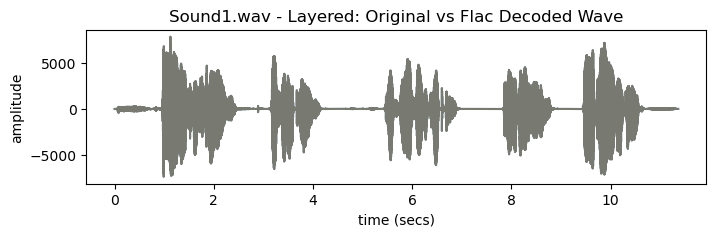

,File Name,Original Sample #,Decoded Sample #,All Samples Status,1st 5 Original Samples,1st 5 Decoded Samples
0,Sound2.wav,"504,000","504,000",Match,"-999, 886, -1325, 886, -1514","-999, 886, -1325, 886, -1514"


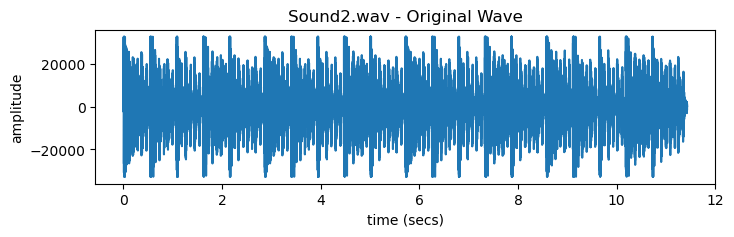

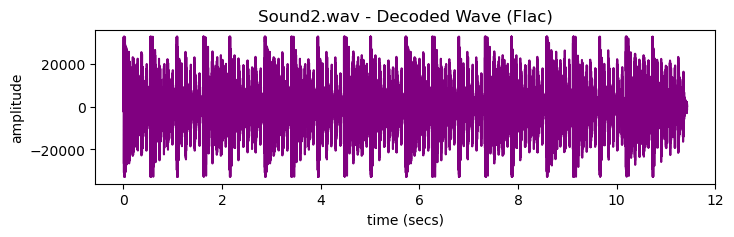

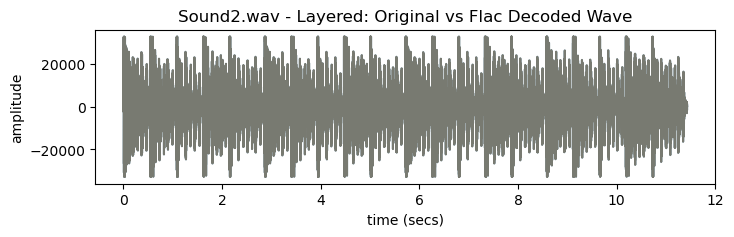

In [12]:
os.environ['PATH'] += os.pathsep + '/usr/local/bin'

# converts wav to flac
def convert_wav_to_flac(wav_file_name):
    # loads WAV
    audio_file = AudioSegment.from_wav(wav_file_name)
    # gets flac file name from wav name
    flac_file_name = wav_file_name.replace('.wav', '_FLAC_Encoded.flac')
    # exports audio as flac format
    audio_file.export(flac_file_name, format="flac")
    return flac_file_name

# convert flac to wav
def convert_flac_to_wav(flac_file_name):
    # loads flac
    audio_file = AudioSegment.from_file(flac_file_name, format="flac")
    # gets wav file name from flac name
    wav_file_name = flac_file_name.replace('_FLAC_Encoded.flac', '_FLAC_Decoded.wav')
    # exports audio as wav
    audio_file.export(wav_file_name, format="wav")
    return wav_file_name

# saves files in flac_coding folder
def save_to_folder(audio_files_paths, target_folder='flac_coding'):
    # verifies folder exists
    os.makedirs(target_folder, exist_ok=True)
    # saves files in the specified folder
    os.rename(audio_files_paths, os.path.join(target_folder, os.path.basename(audio_files_paths)))

# handles encoding and decoding
def compress_audio_with_flac(audio_files_paths, audio_sample_size=5):
    for wav_file in audio_files_paths:
        data_table = []  

        # verifies folder exists
        if not os.path.exists('flac_coding'):
            os.makedirs('flac_coding')

        flac_file = convert_wav_to_flac(wav_file)
        decoded_wav_file = convert_flac_to_wav(flac_file)

        # read original and decoded data
        rate, base_data = wavfile.read(wav_file)
        decoded_data = wavfile.read(decoded_wav_file)[1]

        # checks if samples match
        sample_match_status = "Match" if np.array_equal(base_data, decoded_data) else "Mismatch"

        # add results to data table 
        data_table.append({
                "File Name": os.path.basename(wav_file),
                "Original Sample #": len(base_data),
                "Decoded Sample #": len(decoded_data),
                "All Samples Status": sample_match_status,
                "1st 5 Original Samples": base_data[:audio_sample_size],
                "1st 5 Decoded Samples": decoded_data[:audio_sample_size]
        })

        df = pd.DataFrame(data_table)

        # format and display table
        df_formatted = df.style.format({
            "Original Sample #": "{:,}",
            "Decoded Sample #": "{:,}",
            "1st 5 Original Samples": lambda x: ", ".join(map(str, x)),
            "1st 5 Decoded Samples": lambda x: ", ".join(map(str, x)),
        })
        display(df_formatted)

        # wave visualization 
        wave_visualization(base_data, decoded_data, rate, coding_method="flac", audio_file_name=wav_file)

        # save encoded and decoded files to flac_coding folder
        save_to_folder(flac_file)
        save_to_folder(decoded_wav_file)

audio_files_paths = ['original_audio/Sound1.wav', 'original_audio/Sound2.wav']
compress_audio_with_flac(audio_files_paths)

<a id='allcodinganalysis'></a>
## Comparison Table of Rice, Huffman and FLAC

In [13]:
# this function analyzes flac, huffman and rice compression and displays data table
def analyze_flac__rice_huffman_compression(audio_files_paths, k_values=[2, 4]):
    rows = []

    for file in audio_files_paths:
        get_original_size = os.path.getsize(file)
        
        row = {'File Name': os.path.basename(file), 'Original Size': get_original_size}
        
        # flac coding details
        flac_coding_file_path = os.path.join("flac_coding", file.replace('.wav', '_FLAC_Encoded.flac').replace("original_audio/", ""))
        flac_coding_size = os.path.getsize(flac_coding_file_path)
        flac_coding_compression_ratio = flac_coding_size / get_original_size
        flac_coding_compression_percentage = (1 - flac_coding_compression_ratio) * 100
        if flac_coding_compression_percentage < 0:
            flac_coding_compression_string = f"0.00% ({flac_coding_compression_percentage:.2f}%)"
        else:
            flac_coding_compression_string = f"{flac_coding_compression_percentage:.2f}%"

        row['FLAC Encoded Size'] = flac_coding_size
        row['% Compression (FLAC)'] = flac_coding_compression_string
   
        # rice coding details
        for k in k_values:
            rice_coding_encoded_path = os.path.join("rice_coding", file.replace('.wav', '_Enc_K' + str(k) + '.ex2').replace("original_audio/", ""))
            rice_coding_encoded_size = os.path.getsize(rice_coding_encoded_path)
            rice_coding_compression_ratio = rice_coding_encoded_size / get_original_size
            rice_coding_compression_percentage = (1 - rice_coding_compression_ratio) * 100
            
            if rice_coding_compression_percentage < 0:
                rice_coding_compression_string = f"0.00% ({rice_coding_compression_percentage:.2f}%)"
            else:
                rice_coding_compression_string = f"{rice_coding_compression_percentage:.2f}%"
            
            row[f"Rice (K = {k} bits)"] = rice_coding_encoded_size
            row[f"% Compression (K = {k} bits)"] = rice_coding_compression_string
        
        # huffman coding details
        huffman_coding_encoded_path = os.path.join("huffman_coding", file.replace('.wav', '_Huffman_Encoded.ex2').replace("original_audio/", ""))
        huffman_coding_encoded_size = os.path.getsize(huffman_coding_encoded_path)
        huffman_compression_ratio = huffman_coding_encoded_size / get_original_size
        huffman_coding_compression_percentage = (1 - huffman_compression_ratio) * 100
        if huffman_coding_compression_percentage < 0:
            huffman_coding_compression_string = f"0.00% ({huffman_coding_compression_percentage:.2f}%)"
        else:
            huffman_coding_compression_string = f"{huffman_coding_compression_percentage:.2f}%"
        
        row['Huffman Encoded Size'] = huffman_coding_encoded_size
        row['% Compression (Huffman)'] = huffman_coding_compression_string
        
        rows.append(row)

    # order of columns
    order = ['File Name', 'Original Size', 
                    'Rice (K = 2 bits)', 'Rice (K = 4 bits)', 
                    'Huffman Encoded Size', 
                    'FLAC Encoded Size', 
                    '% Compression (K = 2 bits)', '% Compression (K = 4 bits)', 
                    '% Compression (Huffman)', '% Compression (FLAC)']

    df = pd.DataFrame(rows, columns=order)
    return df


audio_files_paths = ['original_audio/Sound1.wav', 'original_audio/Sound2.wav']
df = analyze_flac__rice_huffman_compression(audio_files_paths)

# formatted table
df_formatted = df.style.format({
    'Original Size': data_size,
    'Rice (K = 2 bits)': data_size,
    'Rice (K = 4 bits)': data_size,
    'Huffman Encoded Size': data_size,
    'FLAC Encoded Size': data_size,
})

display(df_formatted)


,File Name,Original Size,Rice (K = 2 bits),Rice (K = 4 bits),Huffman Encoded Size,FLAC Encoded Size,% Compression (K = 2 bits),% Compression (K = 4 bits),% Compression (Huffman),% Compression (FLAC)
0,Sound1.wav,1.00 MB,4.11 GB,1.03 GB,5.50 MB,340.61 KB,0.00% (-409614.34%),0.00% (-102522.85%),0.00% (-448.68%),66.01%
1,Sound2.wav,1.01 MB,4.14 GB,1.04 GB,8.69 MB,800.75 KB,0.00% (-410677.71%),0.00% (-102788.20%),0.00% (-761.93%),20.56%


<a id='allcodinganalysisbarchart'></a>
## Comparison Bar Chart of Rice, Huffman and FLAC

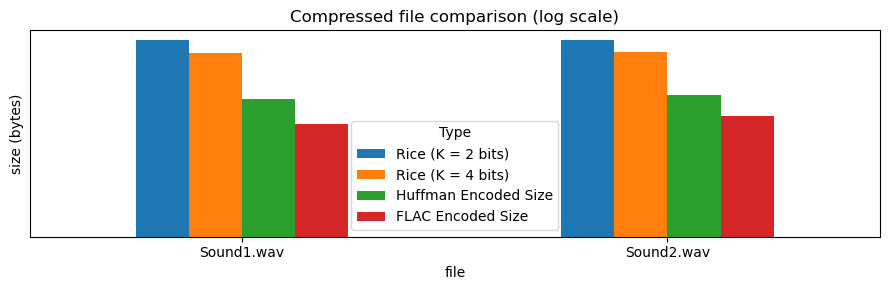

In [14]:
# creates bar chart to compare Rice, Huffman and FLAC results
def comparison_plot_log_sizes(df):
    # get size from columns
    size_cols = ['Rice (K = 2 bits)', 'Rice (K = 4 bits)', 'Huffman Encoded Size', 'FLAC Encoded Size']
    size_df = df[size_cols].copy()

    # change sizes to log scale
    log_size_df = np.log1p(size_df) # to prevent log(0), added 1

    # plot
    ax = log_size_df.plot(kind='bar', figsize=(9, 3))
    ax.set_title("Compressed file comparison (log scale)")
    ax.set_xlabel("file")
    ax.set_ylabel("size (bytes)")
    ax.set_xticklabels(df["File Name"], rotation=0)
    ax.legend(title="Type")
    ax.yaxis.set_ticks([]) # hide y-ticks
    plt.tight_layout()
    plt.show()

comparison_plot_log_sizes(df)

<a id='flacreferences'></a>
## References - FLAC

- https://pydub.com
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html
- https://pandas.pydata.org/docs/
- https://docs.python.org/3/library/os.html
- https://stackoverflow.com/questions/58424108/with-python-how-can-i-convert-a-flac-stream-to-a-wav-stream
- https://snyk.io/advisor/python/pydub/functions/pydub.AudioSegment.from_file
- https://stackoverflow.com/questions/47871357/move-file-to-folders-while-creating-folders
- https://thatascience.com/learn-python/make-directory-safely/
- https://stackoverflow.com/questions/23333678/ffmpeg-to-convert-from-flac-to-wav
- https://gist.github.com/DevAndOps/817dd4b844eb30bce5c29d9e755960e0
- https://community.wolfram.com/groups/-/m/t/2189605

<a id='conclusion'></a>
## Conclusion

The Huffman method is undoubtedly superior to the Rice method, and the FLAC method is superior to both the Huffman and Rice methods. However, both the Rice and Huffman compression methods provided negative compression, and FLAC was the only compression method to provide positive compression, making it the most effective compression method analyzed.